In [86]:
import umap.umap_ as umap
import polars as pl
from transformers import AutoTokenizer, AutoModel
import torch
import tqdm

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [7]:
DATASET = "llm_balanced_test_dataset"
dataset_processed = pl.read_parquet(f"/mnt/sohn2022/Adrian/llm-revise-indication-notes/dataset_curation/{DATASET}_processed.parquet").to_pandas().fillna("None")

In [8]:
MODEL_NAME = "UCSD-VA-health/RadBERT-RoBERTa-4m"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

Some weights of RobertaModel were not initialized from the model checkpoint at UCSD-VA-health/RadBERT-RoBERTa-4m and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
text_embeddings = []
for i in tqdm.tqdm(range(len(dataset_processed))):
    text = dataset_processed.iloc[i]["radiologist_indication"]
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[0]
        embeddings = embeddings.mean(dim=0)
        text_embeddings.append(embeddings)

100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:22<00:00, 38.15it/s]


In [10]:
dataset_processed["embeddings"] = text_embeddings

In [83]:
embeddings = np.stack(dataset_processed["embeddings"].values)  
embeddings_2d = umap.UMAP(
    n_neighbors=30,
    min_dist=0.2, 
).fit_transform(embeddings)

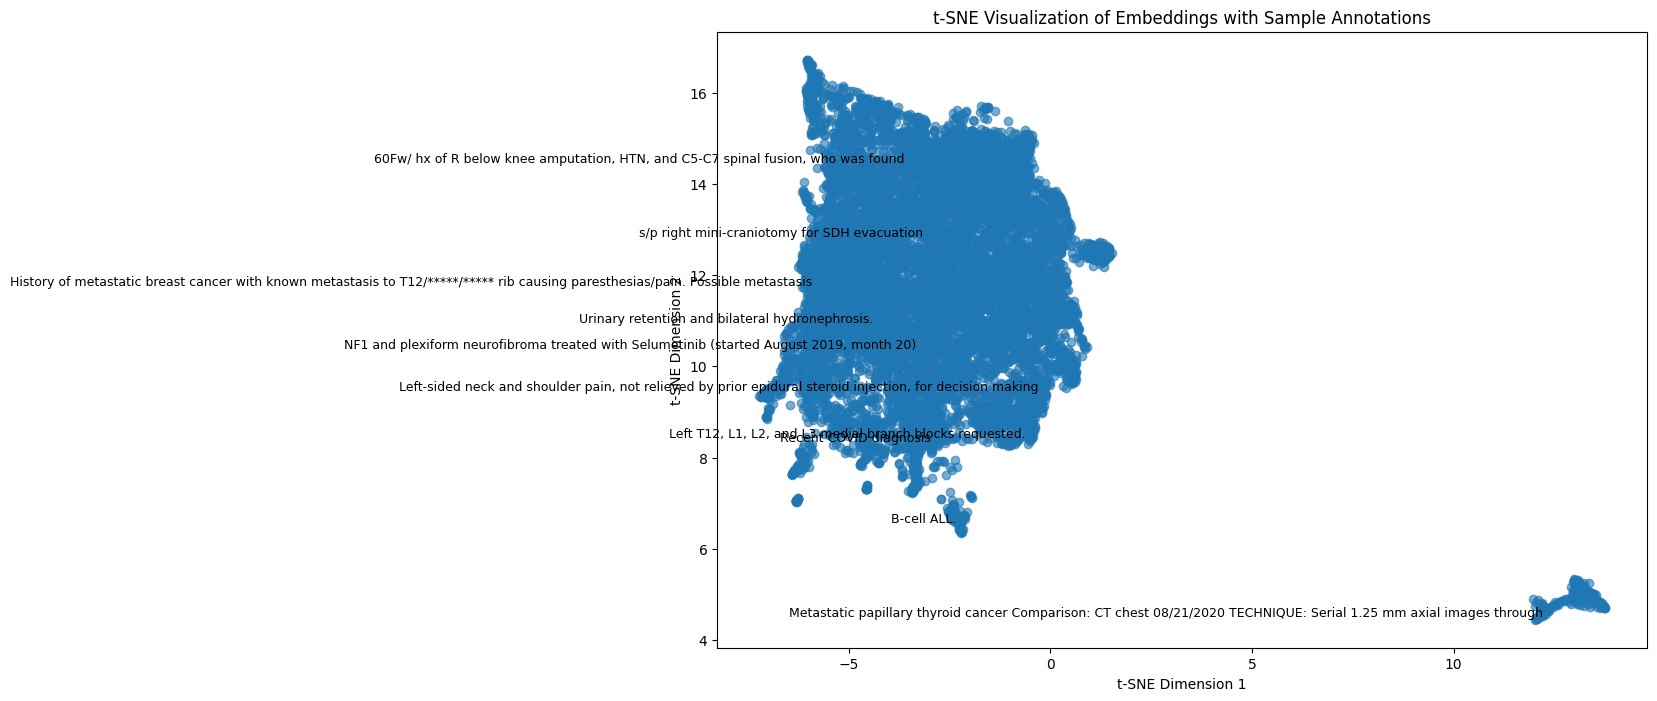

In [84]:
# Add t-SNE results to the DataFrame
dataset_processed['umap_x'] = embeddings_2d[:, 0]
dataset_processed['umap_y'] = embeddings_2d[:, 1]

# Plot t-SNE results
plt.figure(figsize=(12, 8))
plt.scatter(dataset_processed['umap_x'], dataset_processed['umap_y'], alpha=0.6)

# Annotate selected samples with text from 'radiologist_indication'
num_annotations = 10  # Adjust the number of annotations you want
sampled_df = dataset_processed.sample(n=num_annotations)  # Randomly sample for annotation

for _, row in sampled_df.iterrows():
    radiologist_indication = row['radiologist_indication']
    radiologist_indication = ' '.join(radiologist_indication.split()[:15])
    plt.text(row['umap_x'], row['umap_y'], radiologist_indication, fontsize=9, ha='right')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Embeddings with Sample Annotations')
plt.show()


In [88]:
# Set up Nearest Neighbors model to find 5 nearest neighbors
n_neighbors = 5
neighbors_model = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='euclidean')  # +1 to include the point itself
neighbors_model.fit(embeddings)

# Find the nearest neighbors
distances, indices = neighbors_model.kneighbors(embeddings)

# Exclude the point itself (first column) from neighbors
distances = distances[:, 1:]
indices = indices[:, 1:]

# Add neighbors' indices, distances, and radiologist_indications to the DataFrame
for i in range(n_neighbors):
    dataset_processed[f'neighbor_{i+1}_index'] = indices[:, i]
    dataset_processed[f'neighbor_{i+1}_distance'] = distances[:, i]
    dataset_processed[f'neighbor_{i+1}_radiologist_indication'] = dataset_processed.loc[indices[:, i], 'radiologist_indication'].values

# Display the first few rows to verify
print(dataset_processed.head())

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f33d35eb760>
Traceback (most recent call last):
  File "/home/bdrad/miniconda3/envs/report_gen/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/bdrad/miniconda3/envs/report_gen/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/bdrad/miniconda3/envs/report_gen/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/bdrad/miniconda3/envs/report_gen/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


  patientdurablekey                           exam_type imaging_modality  \
0    D78BE72C516739     CT ABDOMEN/PELVIS WITH CONTRAST               CT   
1    DC91572E7BF19B  CT ABDOMEN/PELVIS WITHOUT CONTRAST               CT   
2    DFFBEDA925C6B2     CT ABDOMEN/PELVIS WITH CONTRAST               CT   
3    DC6C83AE0C757F     CT ABDOMEN/PELVIS WITH CONTRAST               CT   
4    DE149F6AD43201     CT ABDOMEN/PELVIS WITH CONTRAST               CT   

       body_group report_deid_note_key  \
0  Abdomen/Pelvis       D3E254FB4EBDC1   
1  Abdomen/Pelvis       D4150F90A708C3   
2  Abdomen/Pelvis       D265CA24A2B5FE   
3  Abdomen/Pelvis       DC53BB784A53E5   
4  Abdomen/Pelvis       D8663073A018AD   

                                         report_text  \
0  CT ABDOMEN/PELVIS WITH CONTRAST  11/07/2022 6:...   
1  CT ABDOMEN/PELVIS WITHOUT CONTRAST    08/23/20...   
2  CT ABDOMEN/PELVIS WITH CONTRAST  11/02/2020 2:...   
3  CT ABDOMEN/PELVIS WITH CONTRAST  11/23/2023 9:...   
4  CT ABDO

In [92]:
dataset_processed.iloc[0]["neighbor_1_radiologist_indication"]

'1 wk of abdominal pain and nausea, no emesis. Started having black stool after taking pepto bismol starting 3 days ago. Epigastric burning pain.'

In [93]:
dataset_processed.iloc[0]["neighbor_2_radiologist_indication"]

'3 days has been having nausea, vomiting and abdominal tenderness. Persistent weakness, fatigue and diarrhea x months w/ recent ***** at'

In [94]:
dataset_processed.iloc[0]["neighbor_3_radiologist_indication"]

'No pmh but out of the medical system for 20 years, p/w 1 month of L abdominal pain, early satiety and 30lbs weight loss'

In [96]:
dataset_processed.iloc[3890]["radiologist_indication"]

'Radical left nephrectomy in the setting of papillary RCC, IVC thrombectomy, splenectomy 09/08/2021 and right renal artery occlusion. New onset A. fib with RVR.'

In [95]:
dataset_processed.iloc[3890]["neighbor_1_radiologist_indication"]

'History of right nephrectomy in 1990s. Left partial nephrectomy for renal cell carcinoma. Presenting with left upper pole for recurrent RCC, status post open partial nephrectomy on 01/24/2017.'

In [97]:
dataset_processed.iloc[3890]["neighbor_2_radiologist_indication"]

'Pancreatic neuroendocrine tumor status post ***** procedure and partial hepatectomy complicated by biloma. Status post ERCP with biliary stent placement 11/10/2018.'

In [98]:
dataset_processed.iloc[3890]["neighbor_3_radiologist_indication"]

'History of coronary artery disease and CABG in 2018, end-stage renal disease with kidney and pancreas transplant in 2020 and subglottic stenosis with T-tube been stent placed. Most recent bronchoscopy 11/18/2022 with patent stent.'

In [99]:
dataset_processed.iloc[3890]["neighbor_4_radiologist_indication"]

'congenital solitary right kidney and clear cell RCC s/p right partial nephrectomy in January 2019 now requiring HD, with worsening pulmonary nodules and biopsy confirming oligometastatic recurrence'

In [100]:
dataset_processed.iloc[3890]["neighbor_5_radiologist_indication"]

'History of metastatic cholangiocarcinoma status post neoadjuvant chemotherapy, extended right hepatectomy, on ivosidenib. Status post left inguinal hernia repair 12/27/2022.'

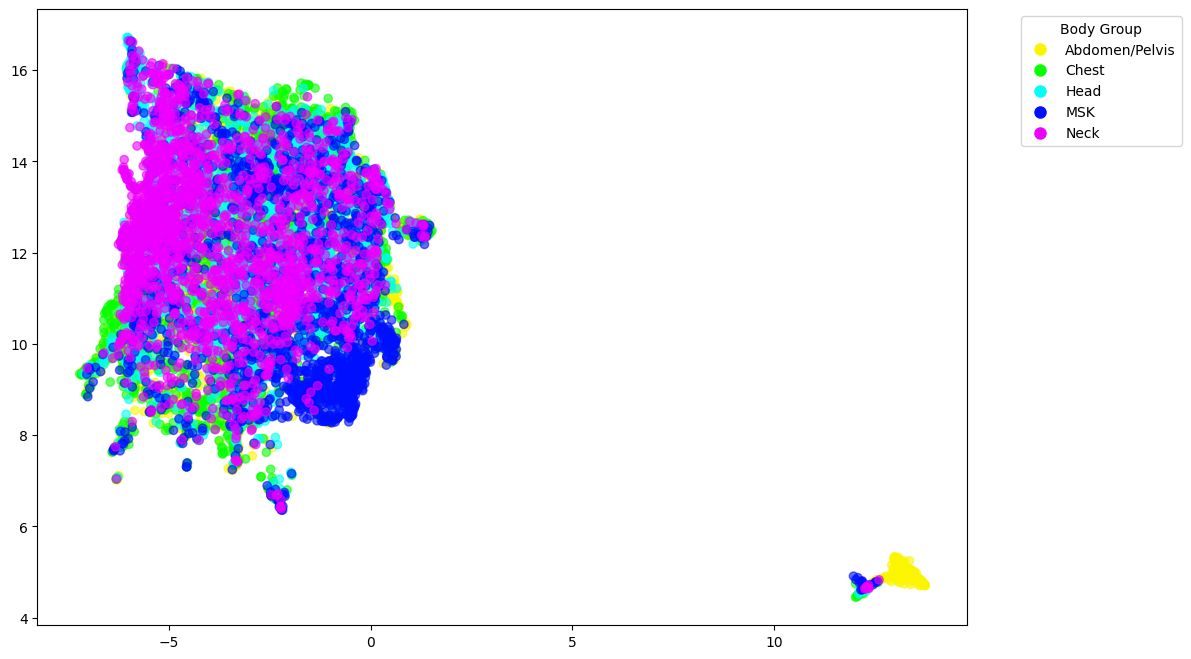

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette for the body groups
unique_body_groups = dataset_processed['body_group'].unique()
palette = sns.color_palette("hsv", len(unique_body_groups))
body_group_colors = {group: palette[i] for i, group in enumerate(unique_body_groups)}

# Map the colors to the body_group column
colors = dataset_processed['body_group'].map(body_group_colors)

# Plot t-SNE results with colors based on body_group
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    dataset_processed['umap_x'],
    dataset_processed['umap_y'],
    c=colors,
    alpha=0.6
)

# Add a legend for body groups
legend_labels = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=8) for color in body_group_colors.values()]
plt.legend(legend_labels, body_group_colors.keys(), title="Body Group", bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate


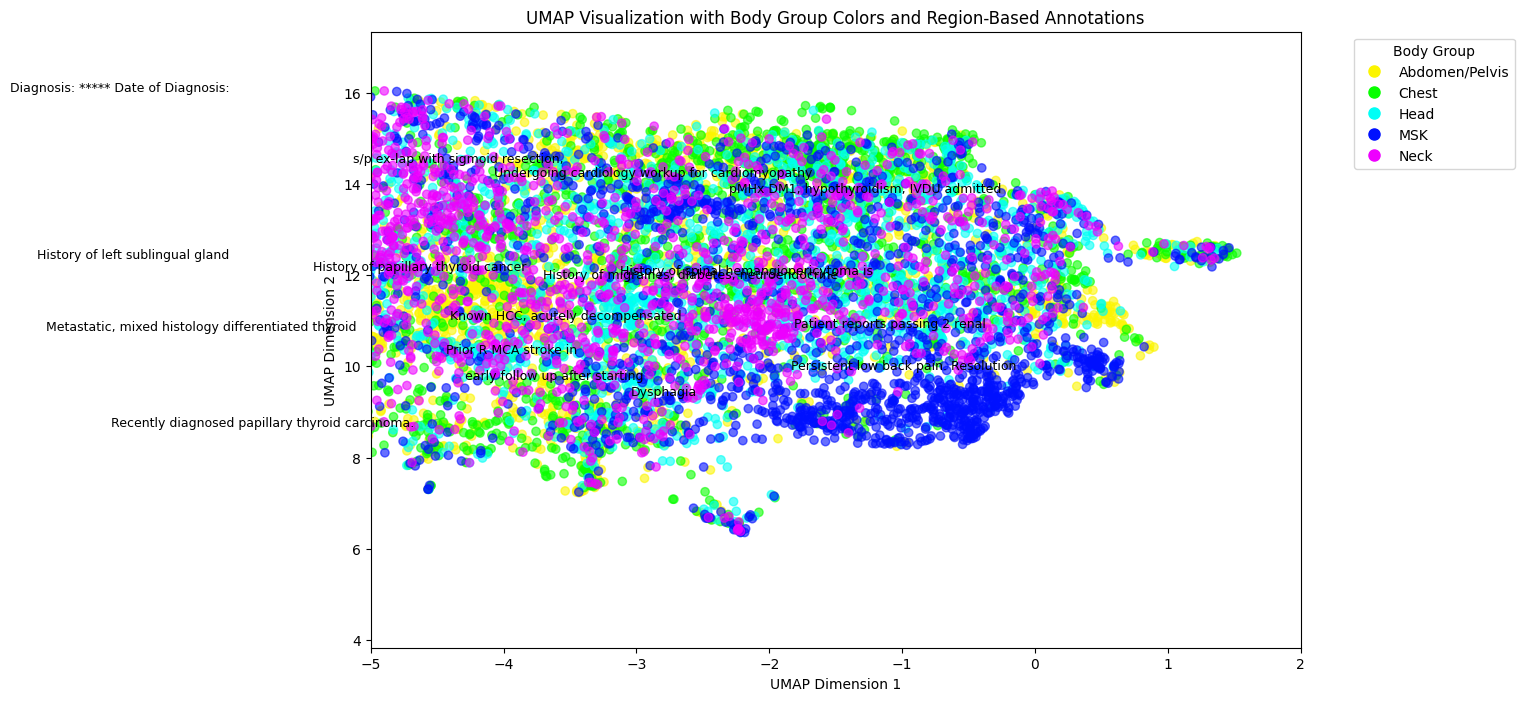

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette for the body groups
unique_body_groups = dataset_processed['body_group'].unique()
palette = sns.color_palette("hsv", len(unique_body_groups))
body_group_colors = {group: palette[i] for i, group in enumerate(unique_body_groups)}

# Map the colors to the body_group column
colors = dataset_processed['body_group'].map(body_group_colors)

# Plot t-SNE/UMAP results with colors based on body_group
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    dataset_processed['umap_x'],
    dataset_processed['umap_y'],
    c=colors,
    alpha=0.6
)

# Add a legend for body groups
legend_labels = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=8) for color in body_group_colors.values()]
plt.legend(legend_labels, body_group_colors.keys(), title="Body Group", bbox_to_anchor=(1.05, 1), loc='upper left')

# Define regions based on quantiles of x and y coordinates
x_quantiles = np.quantile(dataset_processed['umap_x'], [0, 0.25, 0.5, 0.75, 1])
y_quantiles = np.quantile(dataset_processed['umap_y'], [0, 0.25, 0.5, 0.75, 1])

# Sample one point from each of the five regions
for i in range(4):
    for j in range(4):
        region_df = dataset_processed[
            (dataset_processed['umap_x'] >= x_quantiles[i]) & 
            (dataset_processed['umap_x'] < x_quantiles[i+1]) &
            (dataset_processed['umap_y'] >= y_quantiles[j]) & 
            (dataset_processed['umap_y'] < y_quantiles[j+1])
        ]
        if not region_df.empty:
            sample = region_df.sample(n=1, random_state=42)
            x, y = sample['umap_x'].values[0], sample['umap_y'].values[0]
            indication = sample['radiologist_indication'].values[0]
            # Truncate to the first 5 words if needed
            indication = ' '.join(indication.split()[:5])
            plt.text(x, y, indication, fontsize=9, ha='right')

plt.xlim(-5, 2)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization with Body Group Colors and Region-Based Annotations')
plt.show()


In [56]:
dataset_processed[dataset_processed["body_group"] == "Chest"]["umap_x"].mean()

5.032772

In [57]:
dataset_processed[dataset_processed["body_group"] == "Chest"]["umap_y"].mean()

-1.7558054

In [58]:
dataset_processed[dataset_processed["body_group"] == "Abdomen/Pelvis"]["umap_x"].mean()

4.19643

In [59]:
dataset_processed[dataset_processed["body_group"] == "Abdomen/Pelvis"]["umap_y"].mean()

-1.525413

In [40]:
dataset_processed[dataset_processed["umap_x"] > 6][dataset_processed["umap_y"] < -2].iloc[2]["radiologist_indication"]

/tmp/ipykernel_2957983/2927418061.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_processed[dataset_processed["umap_x"] > 6][dataset_processed["umap_y"] < -2].iloc[2]["radiologist_indication"]


'*****-year-old female with past medical history of rectal adenocarcinoma status post low anterior resection presenting for restaging.'

In [53]:
dataset_processed[dataset_processed["umap_x"] > 8][dataset_processed["umap_y"] < -3].iloc[-102]["radiologist_indication"]

/tmp/ipykernel_2957983/2966565342.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_processed[dataset_processed["umap_x"] > 8][dataset_processed["umap_y"] < -3].iloc[-102]["radiologist_indication"]


'Right lower quadrant pain for over 48 hours worsened with urination'

In [36]:
dataset_processed[dataset_processed["umap_x"] < 2.5][dataset_processed["umap_y"] < -2].iloc[1]["radiologist_indication"]

/tmp/ipykernel_2957983/3369352453.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_processed[dataset_processed["umap_x"] < 2.5][dataset_processed["umap_y"] < -2].iloc[1]["radiologist_indication"]


"***** y.o.***** a history of HTN, HFpEF, *****'s gangrene s/***** with end colostomy (2016), spina bifida,chronic ureteral obstruction s/p bilateral nephrostomy tubes, T2DM s/p right BKA,right buttock pressure ulcer s/p failed flap reconstruction (2017),right sided inguinal ulceration,chronic ischial osteomyelitis s/p debridement and flap reconstruction (08/17/20) ***** 2/2ESBL E coli, *****, Enterococcus s/p 6 weeks ***** vancomycin/***** presented with testicular pain, groin wound pain, and abdominal pain."

In [38]:
dataset_processed[dataset_processed["umap_x"] < 2.5][dataset_processed["umap_y"] < -2].iloc[3]["radiologist_indication"]

/tmp/ipykernel_2957983/1007297198.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_processed[dataset_processed["umap_x"] < 2.5][dataset_processed["umap_y"] < -2].iloc[3]["radiologist_indication"]


'Status post bilateral uterine artery embolization, 2.5 pads of ***** Gelfoam slurry on the left and one pad on the right.    TECHNIQUE:  MRI of the pelvis was performed.    MEDICATIONS:  Dotarem - 14 mL - Intravenous    FINDINGS:    GI Tract:  Unremarkable    Vasculature:  Unremarkable    Lymphadenopathy: Absent    Peritoneum: No ascites    Bladder: Unremarkable    Reproductive organs: Postpartum uterus with 2.4 x 1.9 x 2.2 cm (CC x AP x TRV) enhancing mass attached to a thick ***** arising from the posterior uterine body (13/47) extending into the lower uterine cavity, previously 2.5 x 2.3 x 2.9 cm. Markedly decreased arterial vascularity of the mass compared to prior MRA (1128/18) with similar intrinsic internal blood products. Small residual fluid and blood products expanding the endometrial cavity which measures up to 2.5 cm in thickness.    Relative hypoenhancement along the posterior uterine body relative to the remainder of the myometrium at the site of prior placental implanta